In [1]:
import numpy as np
import matplotlib.pyplot as plt

from utils import *

from hcipy import *
# from Keck_aperture import *

%load_ext autoreload
%autoreload 2

# Telescope Setup

We'll start with the Magellan pupil (scaled to 3.048m) until we get a desctription of the Shane Pupil

In [2]:
pupil_diameter = 3.048 # m
collecting_area = np.pi*(3.048**2-0.9779**2)
f_number = 13 #Effective focal ratio
effective_focal_length = pupil_diameter*f_number # m

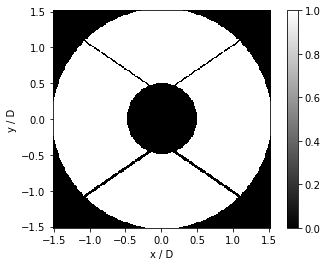

In [3]:
grid_size=256

pupil_grid = make_pupil_grid(grid_size,diameter = pupil_diameter)

#Currently the spiders here do not represent 
telescope_pupil_generator = make_lick_aperture()
telescope_pupil = telescope_pupil_generator(pupil_grid)


im = imshow_field(telescope_pupil, cmap='gray')
plt.colorbar()
plt.xlabel('x / D')
plt.ylabel('y / D')
plt.show()

## Pick some target properties

In [4]:
mag = 5 #Vega magnitude in the band of interest
filter_name = 'V'
exposure_time = 0.001 #exposure time in seconds
wavelength = filters[filter_name]['lambda_eff']*1e-6
stokes_vector= [1,0,0,0.]

pupil_wavefront = Wavefront(telescope_pupil, wavelength,input_stokes_vector=stokes_vector)
pupil_wavefront.total_power = number_of_photons(mag,filter_name,collecting_area,) #In photons/s

## Set up the atmosphere

In [5]:
seeing = 1.75 # Estimating this by eye from here: https://mthamilton.ucolick.org/techdocs/MH_weather/obstats/avg_seeing.html
outer_scale = 40 # meter - GUESS NEEDS TO BE REFINED
velocity = 20 # m/s - GUESS NEDS TO BE REFINED

fried_parameter = seeing_to_fried_parameter(np.radians(seeing/3600),500e-9)
Cn_squared = Cn_squared_from_fried_parameter(fried_parameter, 500e-9)
tau0 = 0.314 * fried_parameter/velocity


print('r0   = {0:.1f}cm'.format(fried_parameter * 100))
print('L0   = {0:.1f}m'.format(outer_scale))
print('tau0 = {0:.1f}ms'.format(tau0 * 1000))
print('v    = {0:.1f}m/s'.format(velocity))

r0   = 5.8cm
L0   = 40.0m
tau0 = 0.9ms
v    = 20.0m/s


In [6]:
layer = InfiniteAtmosphericLayer(pupil_grid, Cn_squared, outer_scale, velocity)

/Users/maxwellmb/Dropbox (Personal)/Library/Python/hcipy/hcipy/util/spectral_noise.py:167: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  S_1 = np.add.reduce(np.ix_(*S_1))
/Users/maxwellmb/Dropbox (Personal)/Library/Python/hcipy/hcipy/util/spectral_noise.py:170: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  S_2 = np.add.reduce(np.ix_(*S_2))


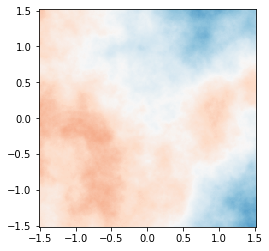

In [7]:
phase_screen_phase = layer.phase_for(wavelength) # in radian
phase_screen_opd = phase_screen_phase * (wavelength / (2 * np.pi)) * 1e6

imshow_field(phase_screen_opd, vmin=-2*np.pi, vmax=2*np.pi, cmap='RdBu')

In [8]:
# wavefront = Wavefront(telescope_pupil,wavelength)
# plt.figure(figsize=(10,8))
# im = imshow_field(layer(wavefront.I).phase*telescope_pupil, cmap='RdBu')
# plt.colorbar()
# plt.xlabel('m')
# plt.ylabel('m')
# plt.show()

# Now propagate to the focal plane

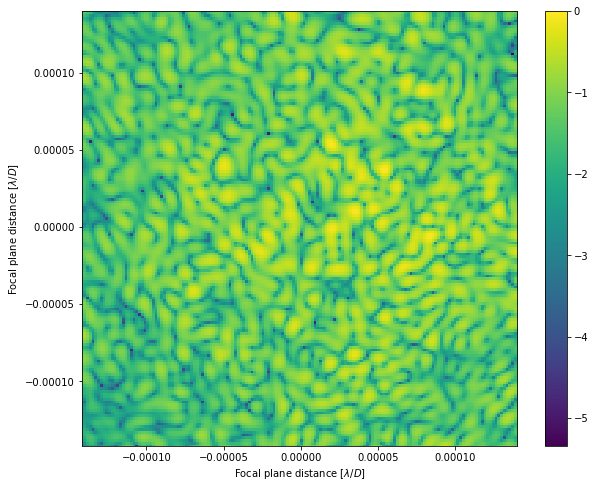

In [9]:
focal_grid = make_focal_grid(q=4, 
                             num_airy=20,
                            pupil_diameter=pupil_diameter,
                            focal_length=effective_focal_length,
                            reference_wavelength=wavelength,
                            )

prop = FraunhoferPropagator(pupil_grid,focal_grid,
                           focal_length=effective_focal_length)

# focal_image = prop.forward(wavefront)
focal_image = prop((layer(pupil_wavefront)))

plt.figure(figsize=(10,8))
imshow_field(np.log10(focal_image.intensity / focal_image.intensity.max()))
plt.xlabel('Focal plane distance [$\lambda/D$]')
plt.ylabel('Focal plane distance [$\lambda/D$]')
plt.colorbar()
plt.show()

## Polarized point source

In [10]:
contrast = 3e-7
stokes_ps = [1,0.3,0.,0.]
angular_separation= 5 #Lambda/D
wf_planet = Wavefront(telescope_pupil*np.exp(2j*np.pi*pupil_grid.x*angular_separation/pupil_diameter),wavelength,
                     input_stokes_vector=stokes_ps)
wf_planet.total_power = contrast*number_of_photons(mag,filter_name,collecting_area,)

## Polarimeter Setup
Our basic polarimeter will have a half-wave plate and a wollaston

In [11]:
HWP = HalfWavePlate(0)

# We'll integrate HWP positions later
# HWP_positions = [0, 45, 22.5, 67.5] # degrees

# The wollaston creates two beams: the ordinary ('o') and extraordinary ('e') beams
# We generate fields for both beams for both the planet and star
wollaston = LinearPolarizingBeamSplitter(0)
star_o, star_e = wollaston(prop(HWP.forward(layer(pupil_wavefront))))
planet_o, planet_e = wollaston(prop(HWP.forward(layer(wf_planet))))

#We need a detector for each beam 
detector_o = NoisyDetector(focal_grid, dark_current_rate=0, read_noise=1, flat_field=0, include_photon_noise=False)
detector_e = NoisyDetector(focal_grid, dark_current_rate=0, read_noise=1, flat_field=0, include_photon_noise=False)

In [12]:
# Get the power at each beam, combining the star and planet
dt = 1 #Integration time
detector_o.power = star_o.power*dt + planet_o.power*dt
detector_e.power = star_e.power*dt + planet_e.power*dt

## Read out the detectors

In [13]:
im_o = detector_o.read_out()
im_e = detector_e.read_out()

Plot it up!

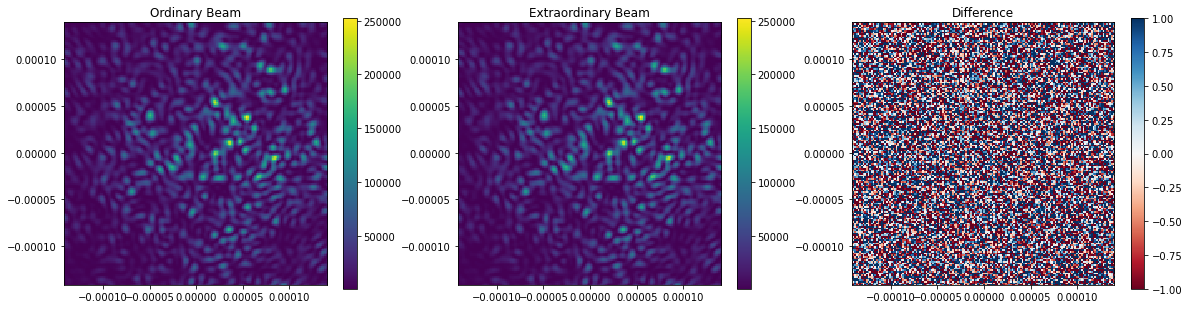

In [14]:
fig,axes = plt.subplots(1,3,figsize=(20,5))
im0 = imshow_field((im_o),ax=axes[0])
im1=imshow_field((im_e),ax=axes[1])
im2=imshow_field((im_o-im_e),ax=axes[2],cmap='RdBu',vmin=-1,vmax=1)

axes[0].set_title("Ordinary Beam")
axes[1].set_title("Extraordinary Beam")
axes[2].set_title("Difference")

plt.colorbar(im0, ax=axes[0])
plt.colorbar(im1, ax=axes[1])
plt.colorbar(im2, ax=axes[2])

# We could also consider a noiseless detector

Set up the Detector

In [15]:
detector_o = NoiselessDetector()
detector_e = NoiselessDetector()

dt=1
#Get the power at each beam, combining the star and planet
detector_o.intensity = star_o.power*dt + planet_o.power*dt ##
detector_e.intensity = star_e.power*dt + planet_e.power*dt

im_o = detector_o.read_out()
im_e = detector_e.read_out()

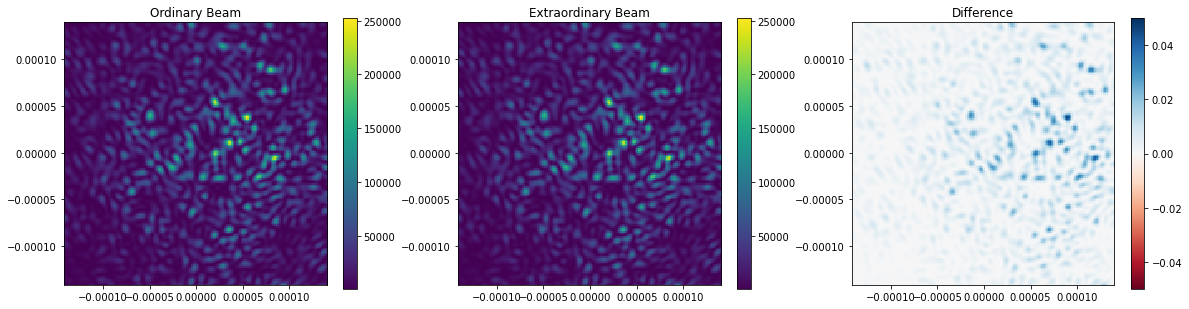

In [16]:
fig,axes = plt.subplots(1,3,figsize=(20,5))
im0 = imshow_field((im_o),ax=axes[0])
im1=imshow_field((im_e),ax=axes[1])
im2=imshow_field((im_o-im_e),ax=axes[2],cmap='RdBu',vmin=-0.05,vmax=0.05)

axes[0].set_title("Ordinary Beam")
axes[1].set_title("Extraordinary Beam")
axes[2].set_title("Difference")

plt.colorbar(im0, ax=axes[0])
plt.colorbar(im1, ax=axes[1])
plt.colorbar(im2, ax=axes[2])

# We can propagate the atmospheric layer: 

/Users/maxwellmb/anaconda3/lib/python3.8/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: The behavior of affine_transform with a 1-D array supplied for the matrix parameter has changed in SciPy 0.18.0.
  warnings.warn(


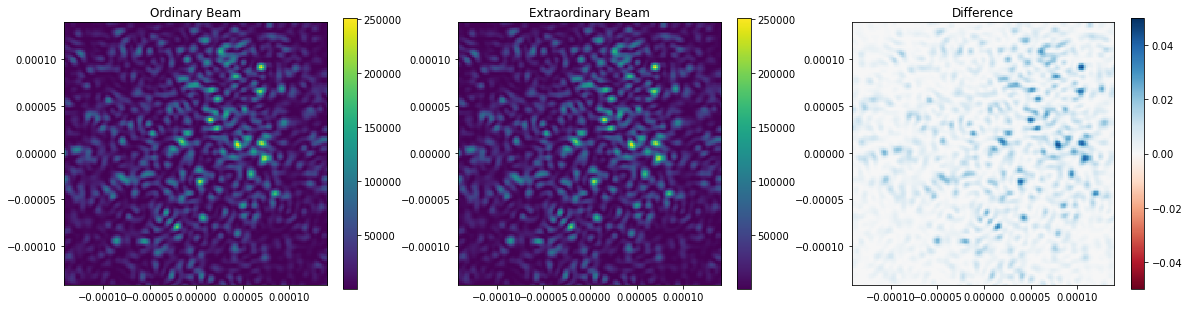

In [17]:
layer.t = 0.1 # sec #Note this is an absolute time, not relative. 
                    #If we move to t=0.2 and then back to t=0.1, it will be the same

star_o, star_e = wollaston(prop(HWP.forward(layer(pupil_wavefront))))
planet_o, planet_e = wollaston(prop(HWP.forward(layer(wf_planet))))

#Get the power at each beam, combining the star and planet
detector_o.intensity = star_o.power*dt + planet_o.power*dt ##
detector_e.intensity = star_e.power*dt + planet_e.power*dt

im_o = detector_o.read_out()
im_e = detector_e.read_out()

fig,axes = plt.subplots(1,3,figsize=(20,5))
im0 = imshow_field((im_o),ax=axes[0])
im1=imshow_field((im_e),ax=axes[1])
im2=imshow_field((im_o-im_e),ax=axes[2],cmap='RdBu',vmin=-0.05,vmax=0.05)

axes[0].set_title("Ordinary Beam")
axes[1].set_title("Extraordinary Beam")
axes[2].set_title("Difference")

plt.colorbar(im0, ax=axes[0])
plt.colorbar(im1, ax=axes[1])
plt.colorbar(im2, ax=axes[2])

# We can rotate the HWP 
(without 

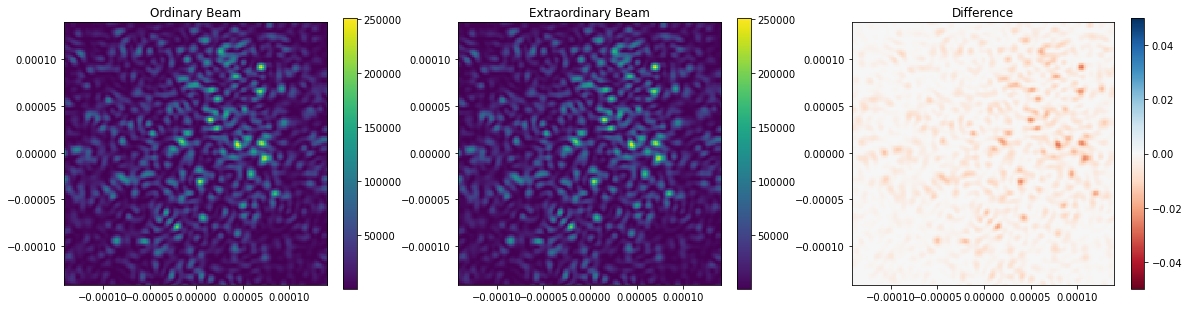

In [18]:
# HWP_positions = [0, 45, 22.5, 67.5] # degrees
HWP = HalfWavePlate(45)

star_o, star_e = wollaston(prop(HWP.forward(layer(pupil_wavefront))))
planet_o, planet_e = wollaston(prop(HWP.forward(layer(wf_planet))))

# Get the power at each beam, combining the star and planet
dt = 1 #Integration time
#Get the power at each beam, combining the star and planet
detector_o.intensity = star_o.power*dt + planet_o.power*dt ##
detector_e.intensity = star_e.power*dt + planet_e.power*dt

im_o = detector_o.read_out()
im_e = detector_e.read_out()

fig,axes = plt.subplots(1,3,figsize=(20,5))
im0 = imshow_field((im_o),ax=axes[0])
im1=imshow_field((im_e),ax=axes[1])
im2=imshow_field((im_o-im_e),ax=axes[2],cmap='RdBu',vmin=-0.05,vmax=0.05)

axes[0].set_title("Ordinary Beam")
axes[1].set_title("Extraordinary Beam")
axes[2].set_title("Difference")

plt.colorbar(im0, ax=axes[0])
plt.colorbar(im1, ax=axes[1])
plt.colorbar(im2, ax=axes[2])